In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
res <- read_tsv("res.tsv",col_names=c("dataset","assembler","ref_tot","ref_cov","ref_cov_frac","qry_tot","qry_cov","qry_cov_frac","contig_num")) %>% replace(is.na(.), 0)
novel <- read_tsv("res_novel.tsv", col_names=c("dataset","assembler","irlen","len","contigs"))
novel <- novel %>% mutate(success = contigs==1 & len>=130000 & irlen>=17000) 


── Column specification ────────────────────────────────────────────────────────
cols(
  dataset = col_character(),
  assembler = col_character(),
  ref_tot = col_double(),
  ref_cov = col_double(),
  ref_cov_frac = col_double(),
  qry_tot = col_double(),
  qry_cov = col_double(),
  qry_cov_frac = col_double(),
  contig_num = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  dataset = col_character(),
  assembler = col_character(),
  irlen = col_double(),
  len = col_double(),
  contigs = col_double()
)


Warning message:
“5 parsing failures.
row col  expected    actual            file
189  -- 5 columns 3 columns 'res_novel.tsv'
431  -- 5 columns 3 columns 'res_novel.tsv'
594  -- 5 columns 3 columns 'res_novel.tsv'
656  -- 5 columns 3 columns 'res_novel.tsv'
657  -- 5 columns 3 columns 'res_novel.tsv'
”


In [6]:
novel %>% colnames

[1] "dataset"   "assembler" "irlen"     "len"       "contigs"   "success"

In [7]:
data <- res %>% left_join(select(novel,dataset,assembler,irlen,success), by=c("dataset","assembler"))

In [8]:
head(data)

dataset,assembler,ref_tot,ref_cov,ref_cov_frac,qry_tot,qry_cov,qry_cov_frac,contig_num,irlen,success
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
SRR1946270,chloroExtractor,154478,125211,0.8105426,125297,125216,0.9993535,8,44,FALSE
SRR1946270,GetOrganelle,154478,154360,0.9992361,154445,154360,0.9994496,1,26263,TRUE
SRR1946270,NOVO-Plasty,154478,154356,0.9992102,287114,286934,0.9993731,4,18082,FALSE
SRR1946271,chloroExtractor,154478,134774,0.8724479,108717,108568,0.9986295,12,44,FALSE
SRR1946271,Fast-Plast,154478,154186,0.9981098,154275,154186,0.9994231,1,26263,TRUE
SRR1946271,GetOrganelle,154478,154185,0.9981033,154275,154185,0.9994166,1,26263,TRUE


In [9]:
options(repr.plot.res=200)

In [10]:
theme_set(theme_light())

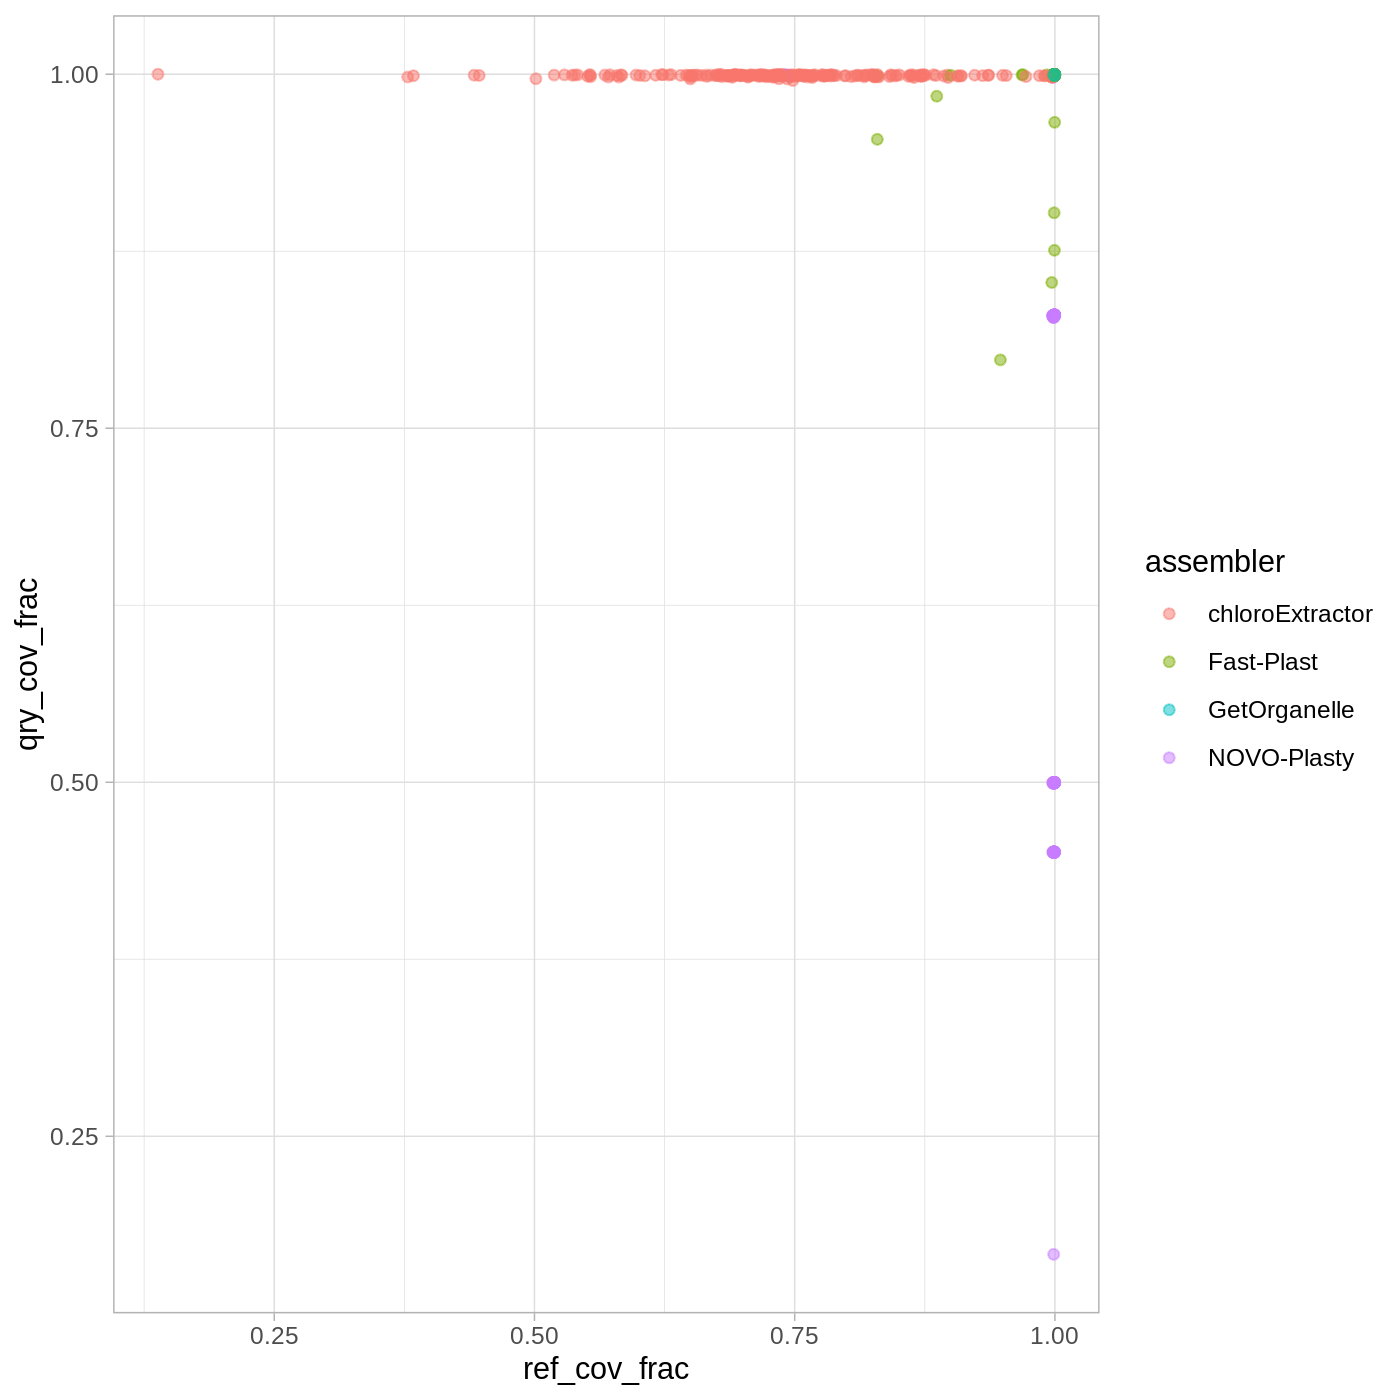

In [11]:
ggplot(data, aes(ref_cov_frac, qry_cov_frac, color=assembler)) + geom_point(alpha=.5)

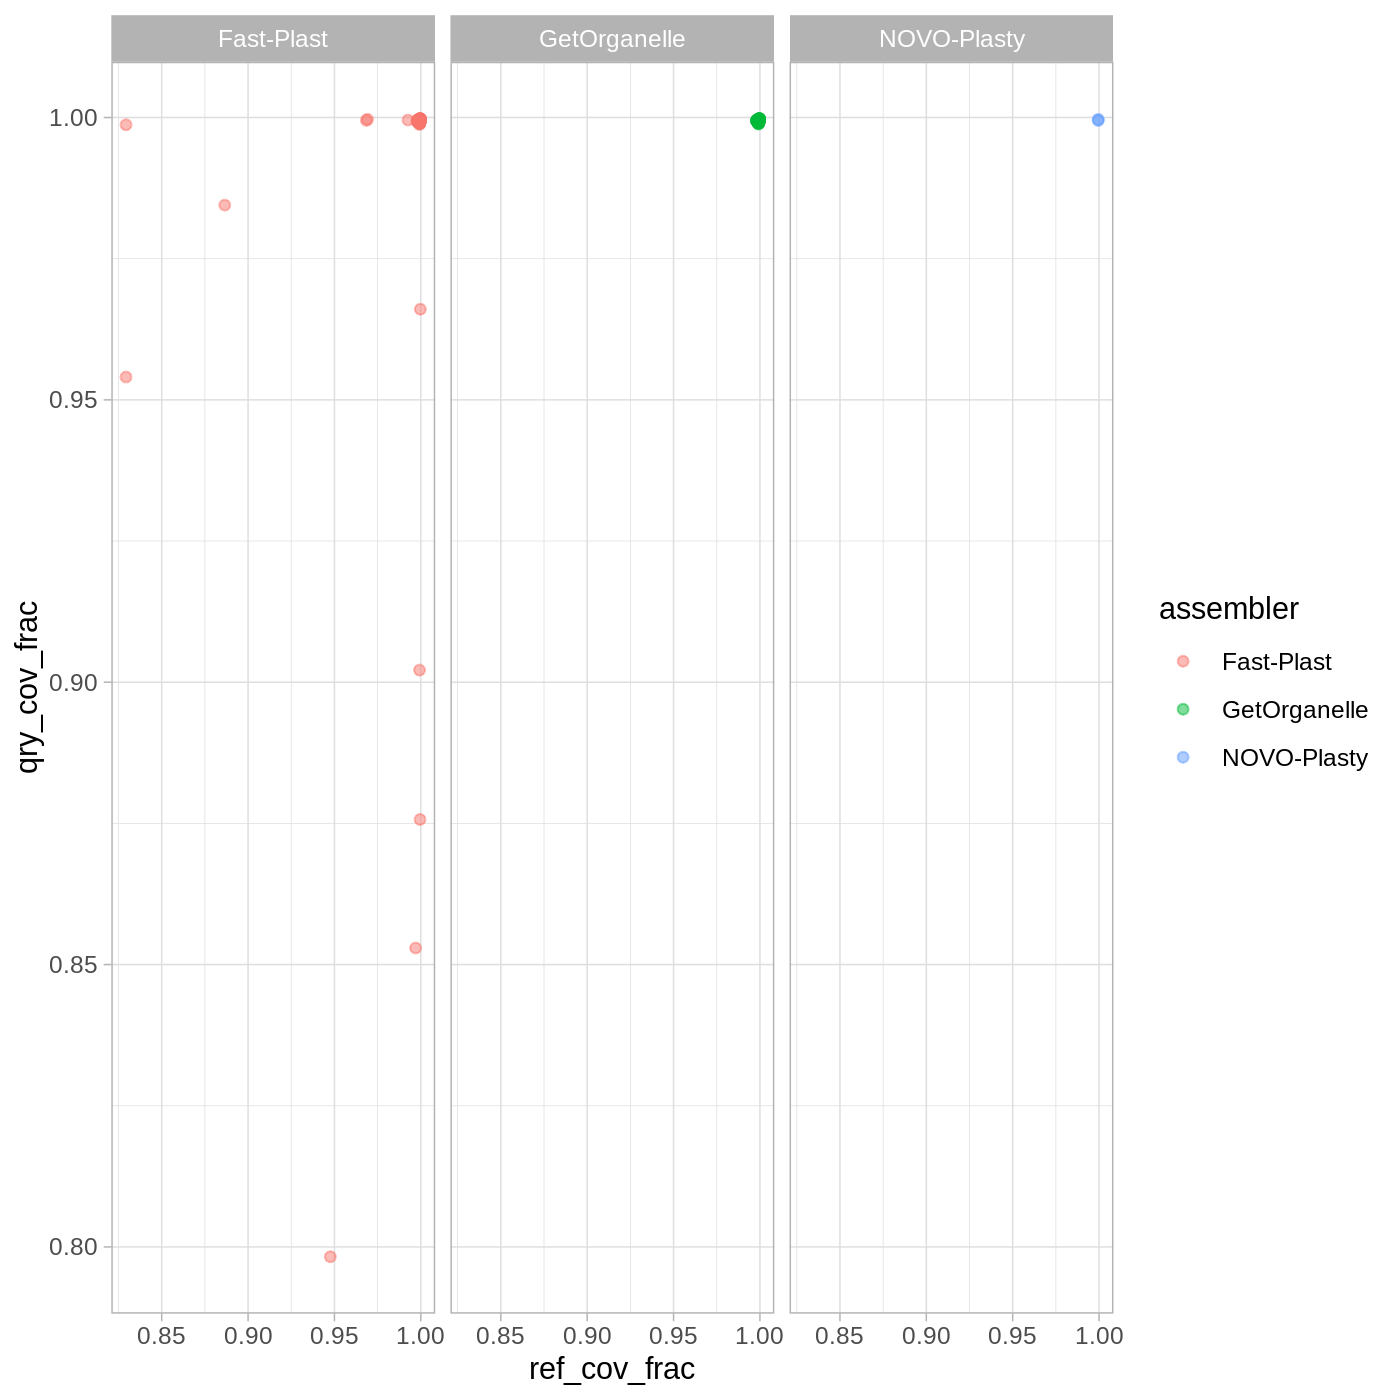

In [13]:
ggplot(data %>% filter(success), aes(ref_cov_frac, qry_cov_frac, color=assembler)) + geom_point(alpha=.5) + facet_wrap(~ assembler)

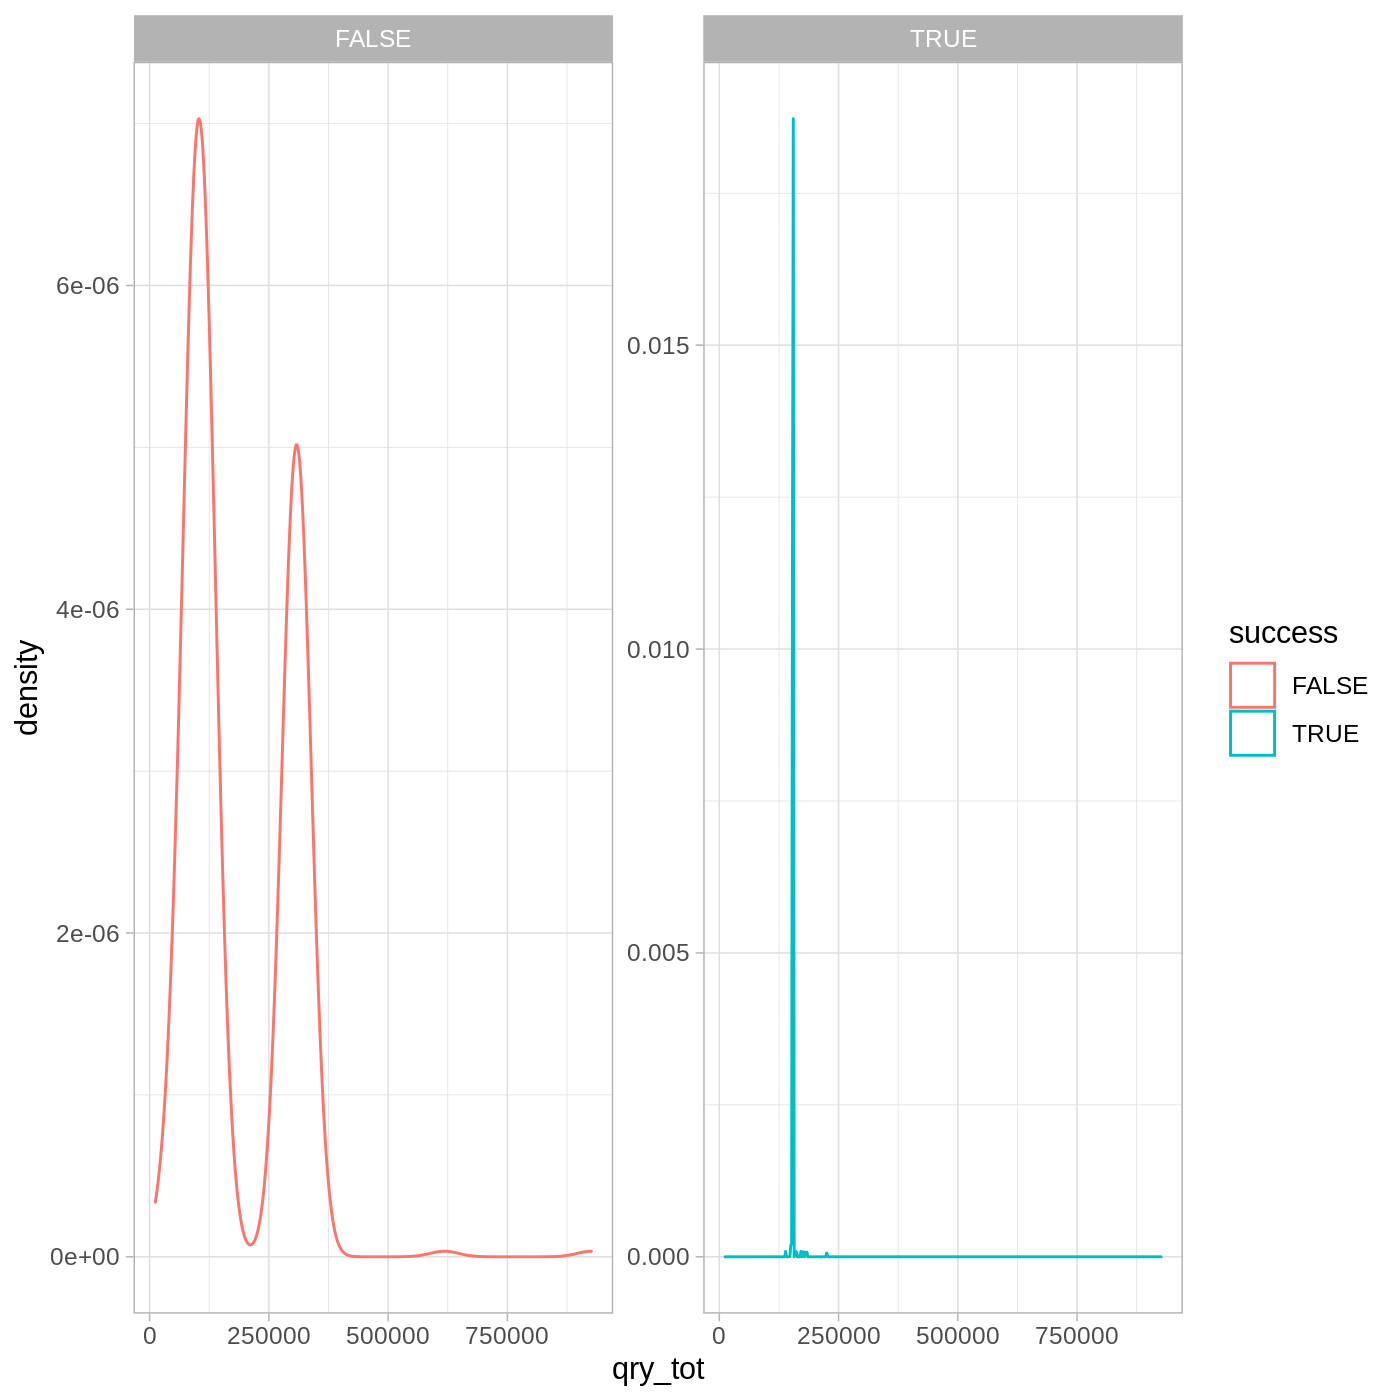

In [14]:
ggplot(data, aes(qry_tot,color=success)) + geom_density() + facet_wrap(~ success, scales="free_y")

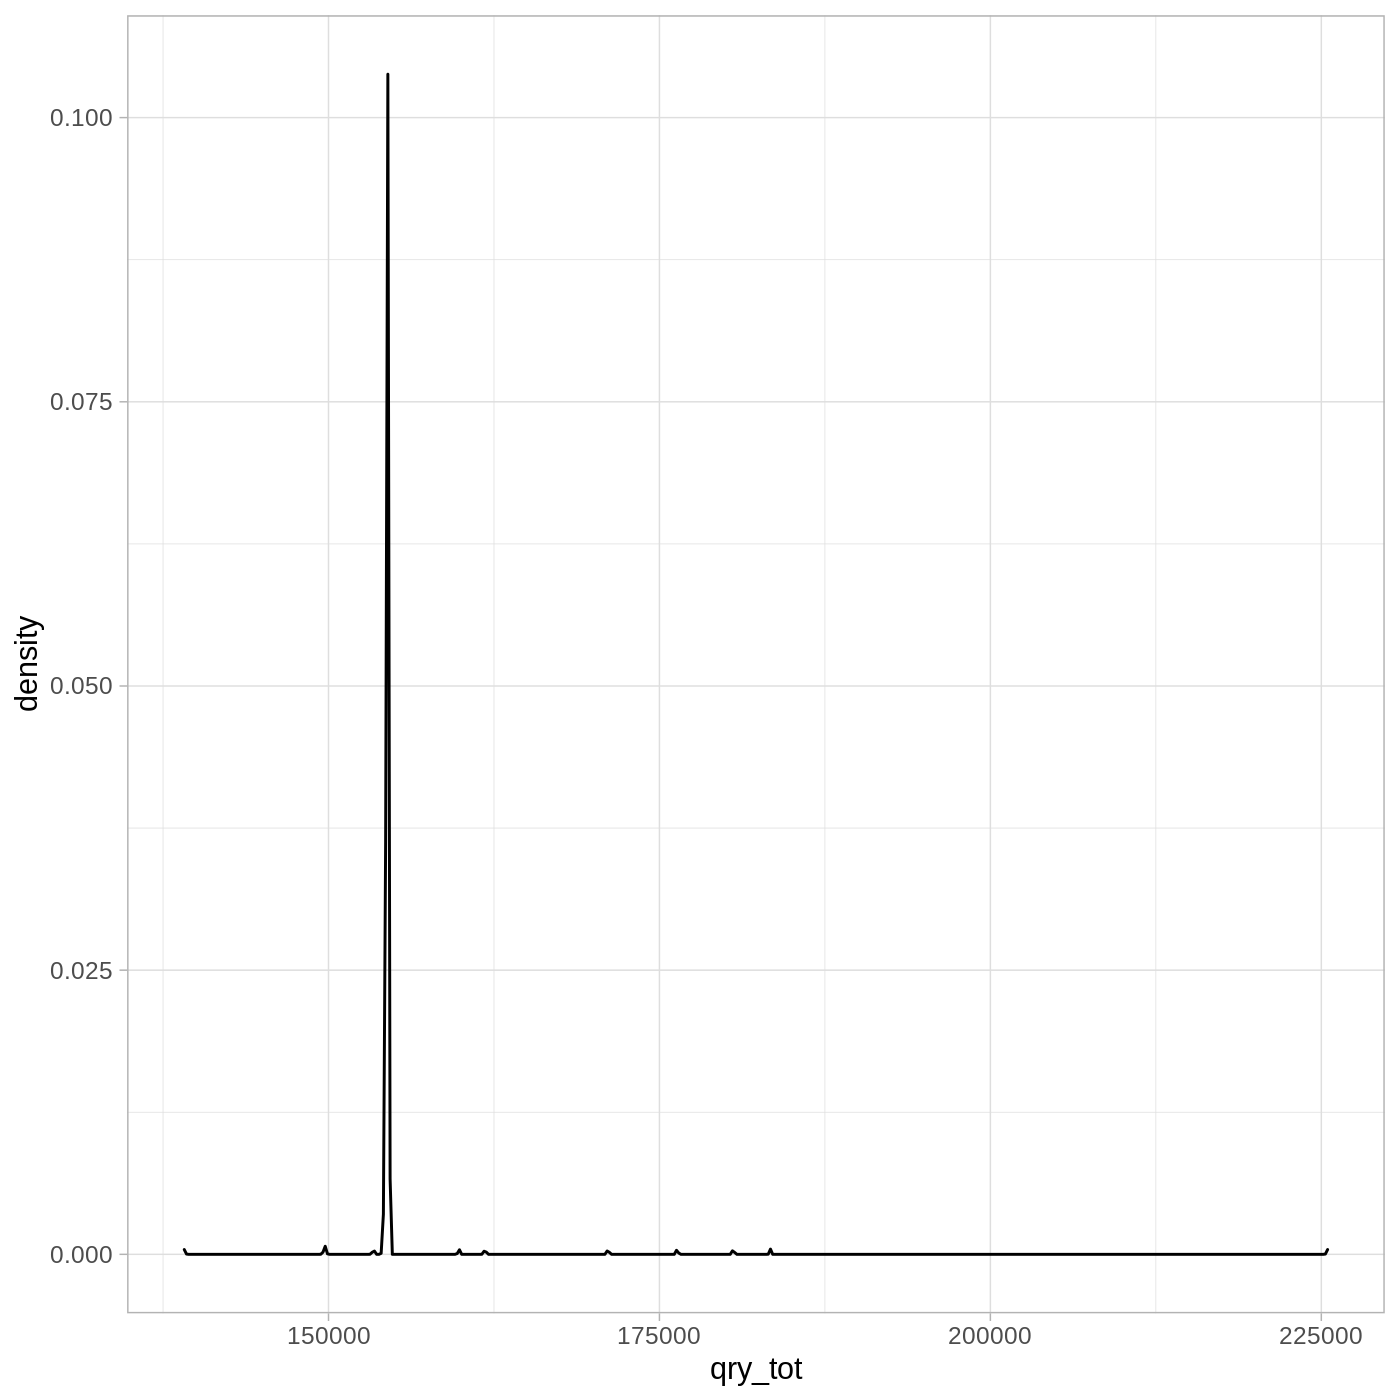

In [15]:
data %>% filter(success) %>% ggplot(aes(qry_tot)) + geom_density(adjust=.2)

In [16]:
summary((data %>% filter(success))$qry_tot)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 139102  154422  154454  154907  154483  225476 

In [17]:
data %>% filter(success) %>% sample_n(10)

dataset,assembler,ref_tot,ref_cov,ref_cov_frac,qry_tot,qry_cov,qry_cov_frac,contig_num,irlen,success
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
SRR1946553,GetOrganelle,154478,154415,0.9995922,154482,154415,0.9995663,1,26263,TRUE
SRR1946432,Fast-Plast,154478,154385,0.9993980,154443,154385,0.9996245,1,26263,TRUE
SRR1946392,GetOrganelle,154478,154384,0.9993915,154444,154384,0.9996115,1,26263,TRUE
SRR1946298,GetOrganelle,154478,154333,0.9990614,154420,154333,0.9994366,1,26263,TRUE
SRR1946380,Fast-Plast,154478,154361,0.9992426,154434,154361,0.9995273,1,26264,TRUE
SRR1946441,Fast-Plast,154478,154419,0.9996181,154479,154419,0.9996116,1,26263,TRUE
SRR1946466,Fast-Plast,154478,154334,0.9990678,154420,154334,0.9994431,1,26263,TRUE
SRR1946312,GetOrganelle,154478,154374,0.9993268,154526,154374,0.9990163,1,26263,TRUE
SRR1946412,GetOrganelle,154478,154355,0.9992038,154433,154355,0.9994949,1,26263,TRUE


In [18]:
dim(data)

[1] 711  11

In [19]:
data <- data %>% mutate(rep_res = exp(-abs(log(qry_cov/ref_cov)))) %>%
    mutate(score =  (1 - ((abs(1-ref_cov_frac)/4) + (abs(1-qry_cov_frac)/4) + (abs(1-rep_res)/4) + (abs(1-(1/contig_num))/4)))*100) %>% replace(is.na(.), 0)

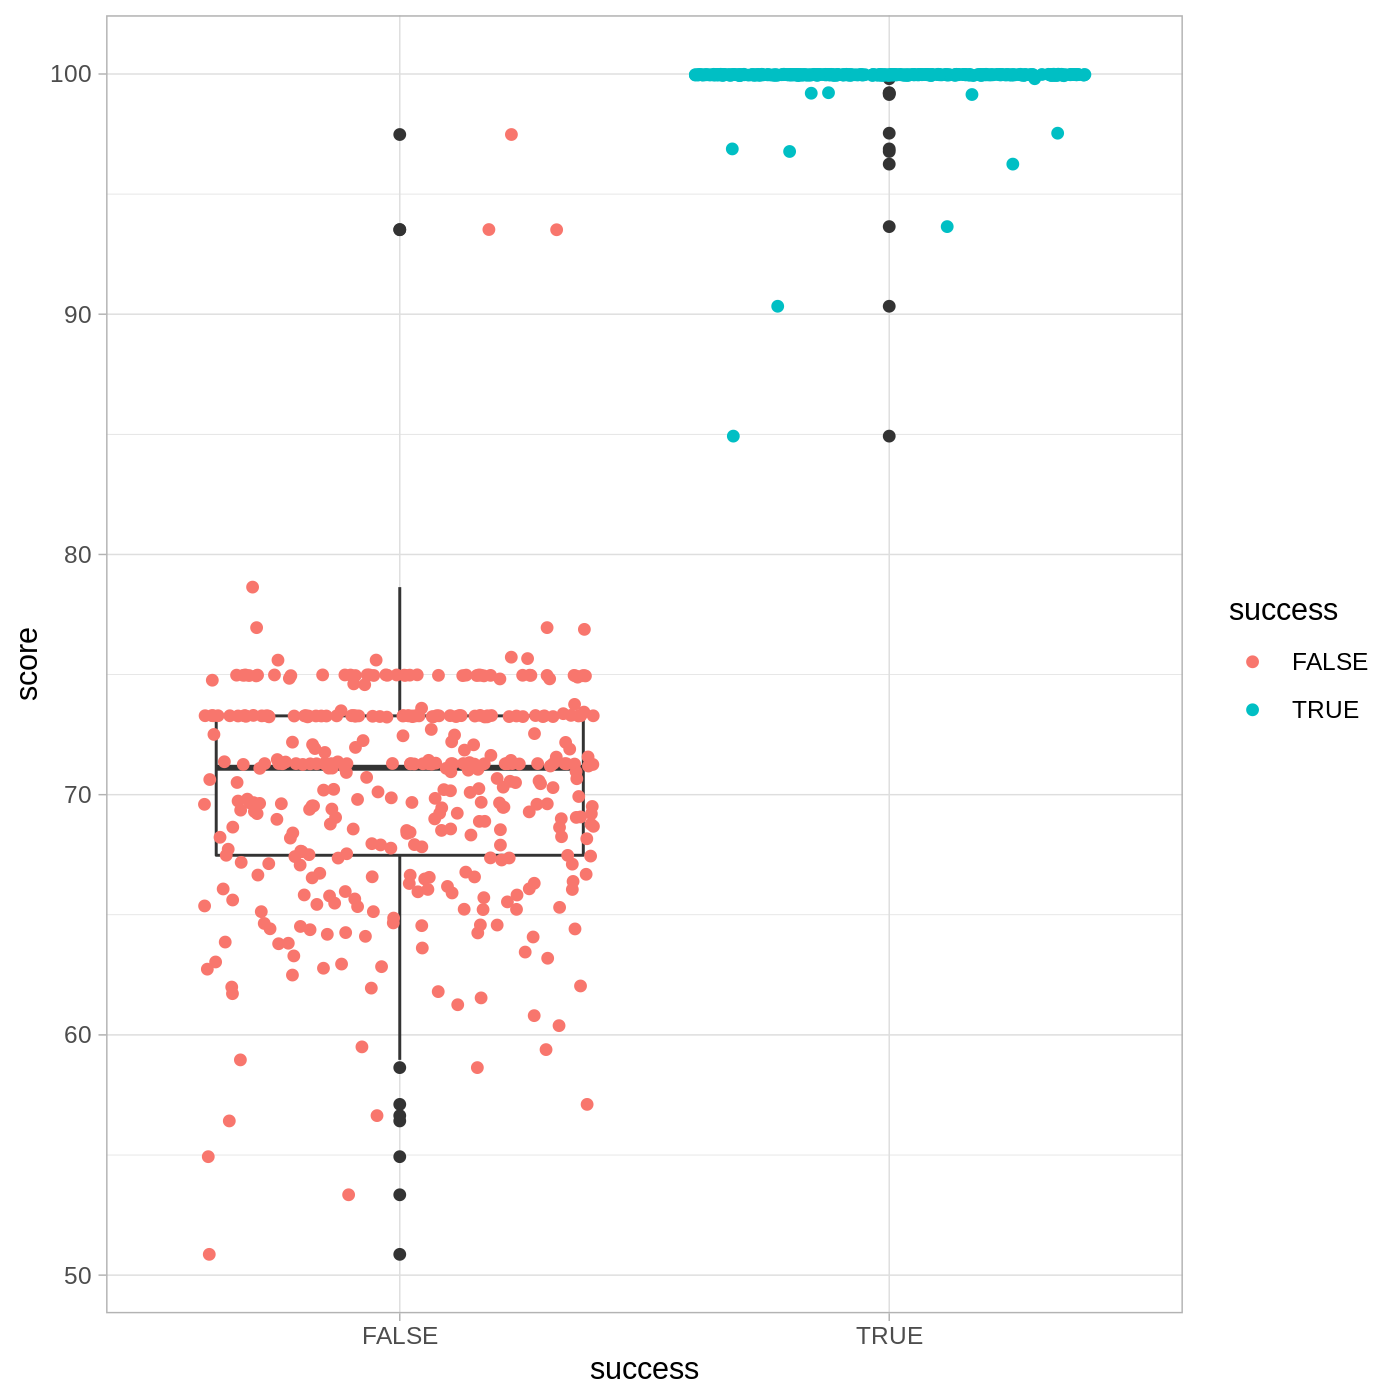

In [20]:
ggplot(data, aes(x=success, y=score)) + geom_boxplot() + geom_jitter(aes(color=success))

In [23]:
data %>% filter(success, score>95) %>% pull(dataset) %>% unique %>% length

[1] 215

In [24]:
data %>% filter(success, score>95) %>% pull(dataset) %>% unique

[1] "SRR1946270" "SRR1946271" "SRR1946272" "SRR1946273" "SRR1946274"
  [6] "SRR1946275" "SRR1946276" "SRR1946277" "SRR1946278" "SRR1946279"
 [11] "SRR1946280" "SRR1946281" "SRR1946282" "SRR1946283" "SRR1946284"
 [16] "SRR1946285" "SRR1946286" "SRR1946287" "SRR1946288" "SRR1946289"
 [21] "SRR1946290" "SRR1946291" "SRR1946292" "SRR1946293" "SRR1946294"
 [26] "SRR1946295" "SRR1946296" "SRR1946297" "SRR1946298" "SRR1946299"
 [31] "SRR1946301" "SRR1946302" "SRR1946303" "SRR1946304" "SRR1946305"
 [36] "SRR1946307" "SRR1946308" "SRR1946309" "SRR1946310" "SRR1946312"
 [41] "SRR1946313" "SRR1946314" "SRR1946315" "SRR1946316" "SRR1946317"
 [46] "SRR1946318" "SRR1946319" "SRR1946320" "SRR1946321" "SRR1946322"
 [51] "SRR1946323" "SRR1946324" "SRR1946325" "SRR1946326" "SRR1946327"
 [56] "SRR1946330" "SRR1946331" "SRR1946332" "SRR1946333" "SRR1946334"
 [61] "SRR1946335" "SRR1946336" "SRR1946337" "SRR1946338" "SRR1946339"
 [66] "SRR1946340" "SRR1946341" "SRR1946342" "SRR1946343" "SRR1946344"
 [71] "SRR1946345" "SRR1946347" "SRR1946348" "SRR1946350" "SRR1946351"
 [76] "SRR1946352" "SRR1946353" "SRR1946354" "SRR1946355" "SRR1946356"
 [81] "SRR1946357" "SRR1946358" "SRR1946359" "SRR1946362" "SRR1946364"
 [86] "SRR1946366" "SRR1946367" "SRR1946368" "SRR1946369" "SRR1946371"
 [91] "SRR1946372" "SRR1946373" "SRR1946375" "SRR1946376" "SRR1946377"
 [96] "SRR1946378" "SRR1946379" "SRR1946380" "SRR1946381" "SRR1946382"
[101] "SRR1946383" "SRR1946384" "SRR1946385" "SRR1946386" "SRR1946387"
[106] "SRR1946388" "SRR1946389" "SRR1946390" "SRR1946391" "SRR1946392"
[111] "SRR1946393" "SRR1946394" "SRR1946395" "SRR1946396" "SRR1946397"
[116] "SRR1946398" "SRR1946399" "SRR1946400" "SRR1946401" "SRR1946402"
[121] "SRR1946403" "SRR1946404" "SRR1946405" "SRR1946406" "SRR1946407"
[126] "SRR1946408" "SRR1946409" "SRR1946410" "SRR1946411" "SRR1946412"
[131] "SRR1946413" "SRR1946414" "SRR1946415" "SRR1946416" "SRR1946417"
[136] "SRR1946418" "SRR1946419" "SRR1946420" "SRR1946421" "SRR1946422"
[141] "SRR1946423" "SRR1946424" "SRR1946425" "SRR1946426" "SRR1946427"
[146] "SRR1946428" "SRR1946429" "SRR1946430" "SRR1946431" "SRR1946432"
[151] "SRR1946433" "SRR1946435" "SRR1946436" "SRR1946437" "SRR1946438"
[156] "SRR1946439" "SRR1946440" "SRR1946441" "SRR1946442" "SRR1946443"
[161] "SRR1946444" "SRR1946445" "SRR1946446" "SRR1946447" "SRR1946448"
[166] "SRR1946449" "SRR1946450" "SRR1946451" "SRR1946452" "SRR1946453"
[171] "SRR1946454" "SRR1946455" "SRR1946456" "SRR1946457" "SRR1946458"
[176] "SRR1946459" "SRR1946460" "SRR1946461" "SRR1946462" "SRR1946463"
[181] "SRR1946464" "SRR1946465" "SRR1946466" "SRR1946467" "SRR1946468"
[186] "SRR1946469" "SRR1946470" "SRR1946471" "SRR1946472" "SRR1946473"
[191] "SRR1946474" "SRR1946475" "SRR1946476" "SRR1946477" "SRR1946478"
[196] "SRR1946479" "SRR1946480" "SRR1946481" "SRR1946482" "SRR1946553"
[201] "SRR1946554" "SRR1946555" "SRR1946556" "SRR1946557" "SRR1946558"
[206] "SRR1946560" "SRR1946561" "SRR1946562" "SRR1946563" "SRR1946564"
[211] "SRR1946565" "SRR1946566" "SRR1946567" "SRR1946568" "SRR1946569"

In [25]:
data %>% filter(success, score>95) %>% count(assembler)

assembler,n
<chr>,<int>
Fast-Plast,195
GetOrganelle,126
NOVO-Plasty,2


In [27]:
library(UpSetR)

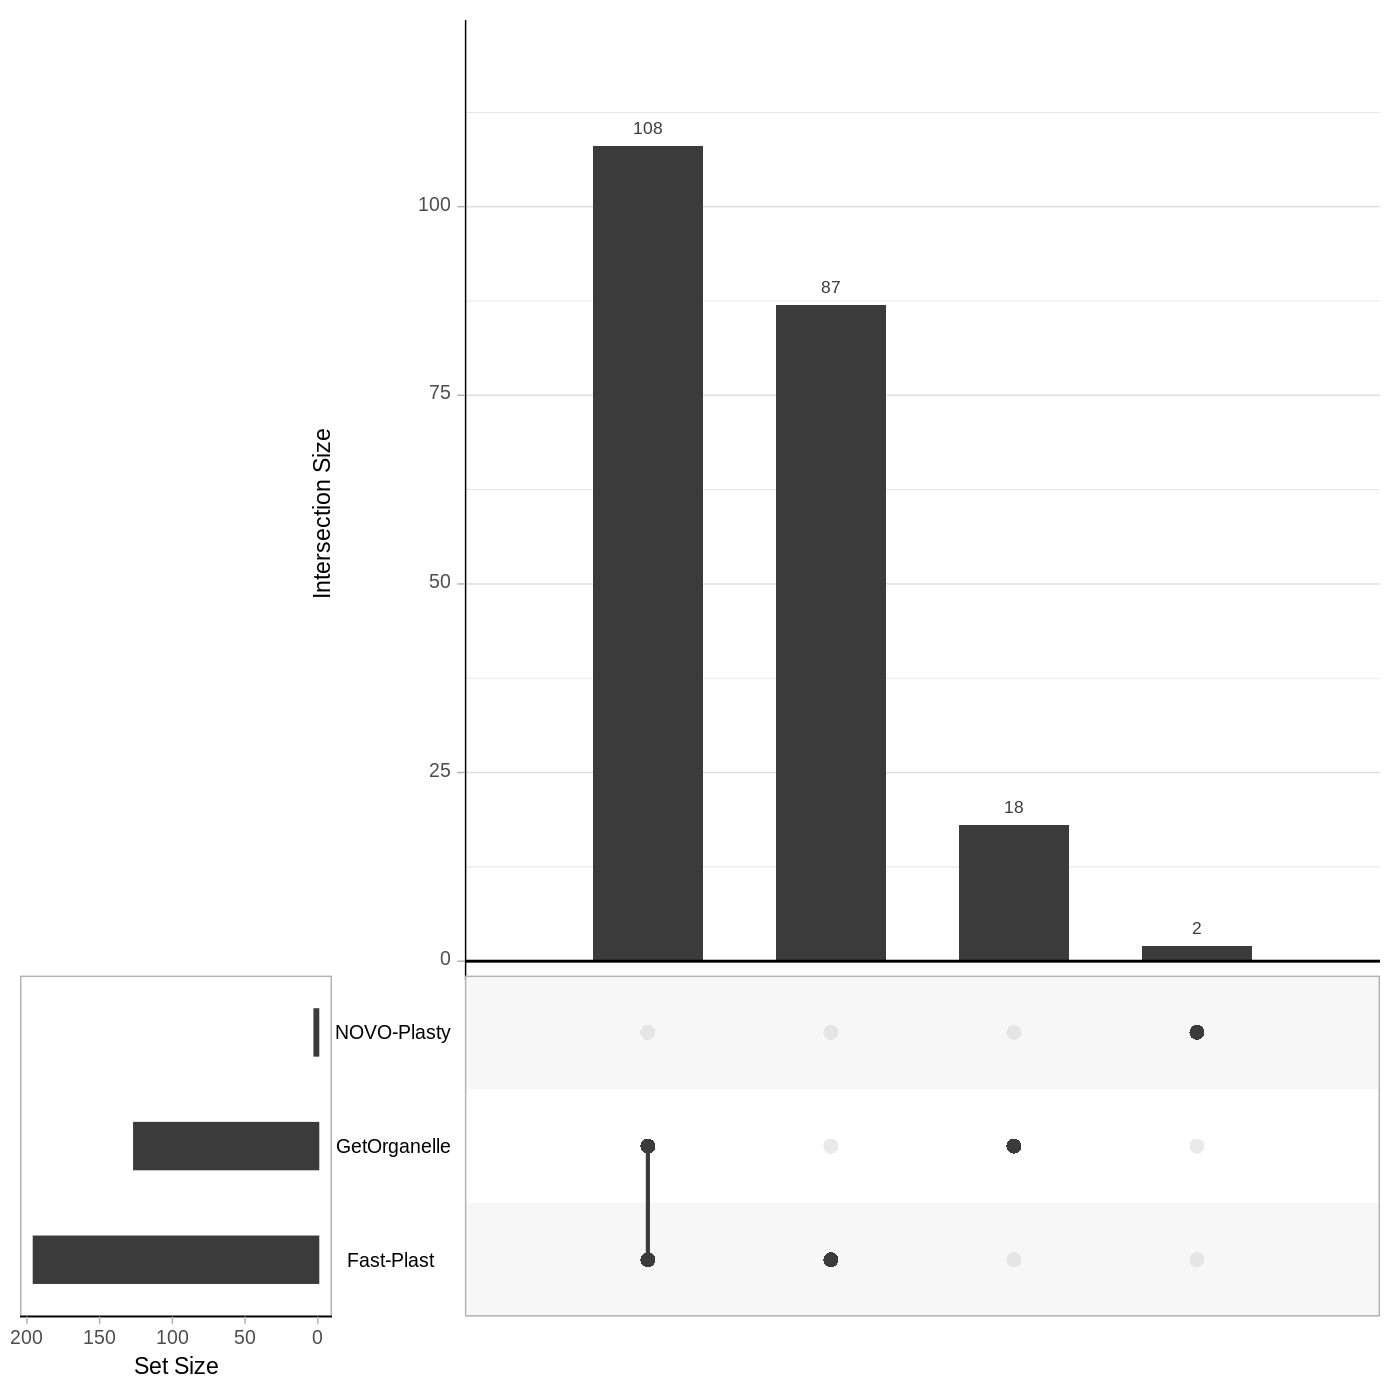

In [28]:
UL = data %>% filter(success, score>95) %>% select(dataset,assembler) %>% split(.$assembler) %>% lapply("[[",1)
upset(fromList(UL), order.by = "freq")#,sets.bar.color=my_col[c(4,3,6,7,2)],
      #point.size=5,matrix.color = my_col[3],
      #shade.alpha = 0.5, text.scale = 1.5)

In [29]:
data %>% pull(dataset) %>% unique %>% length

[1] 232

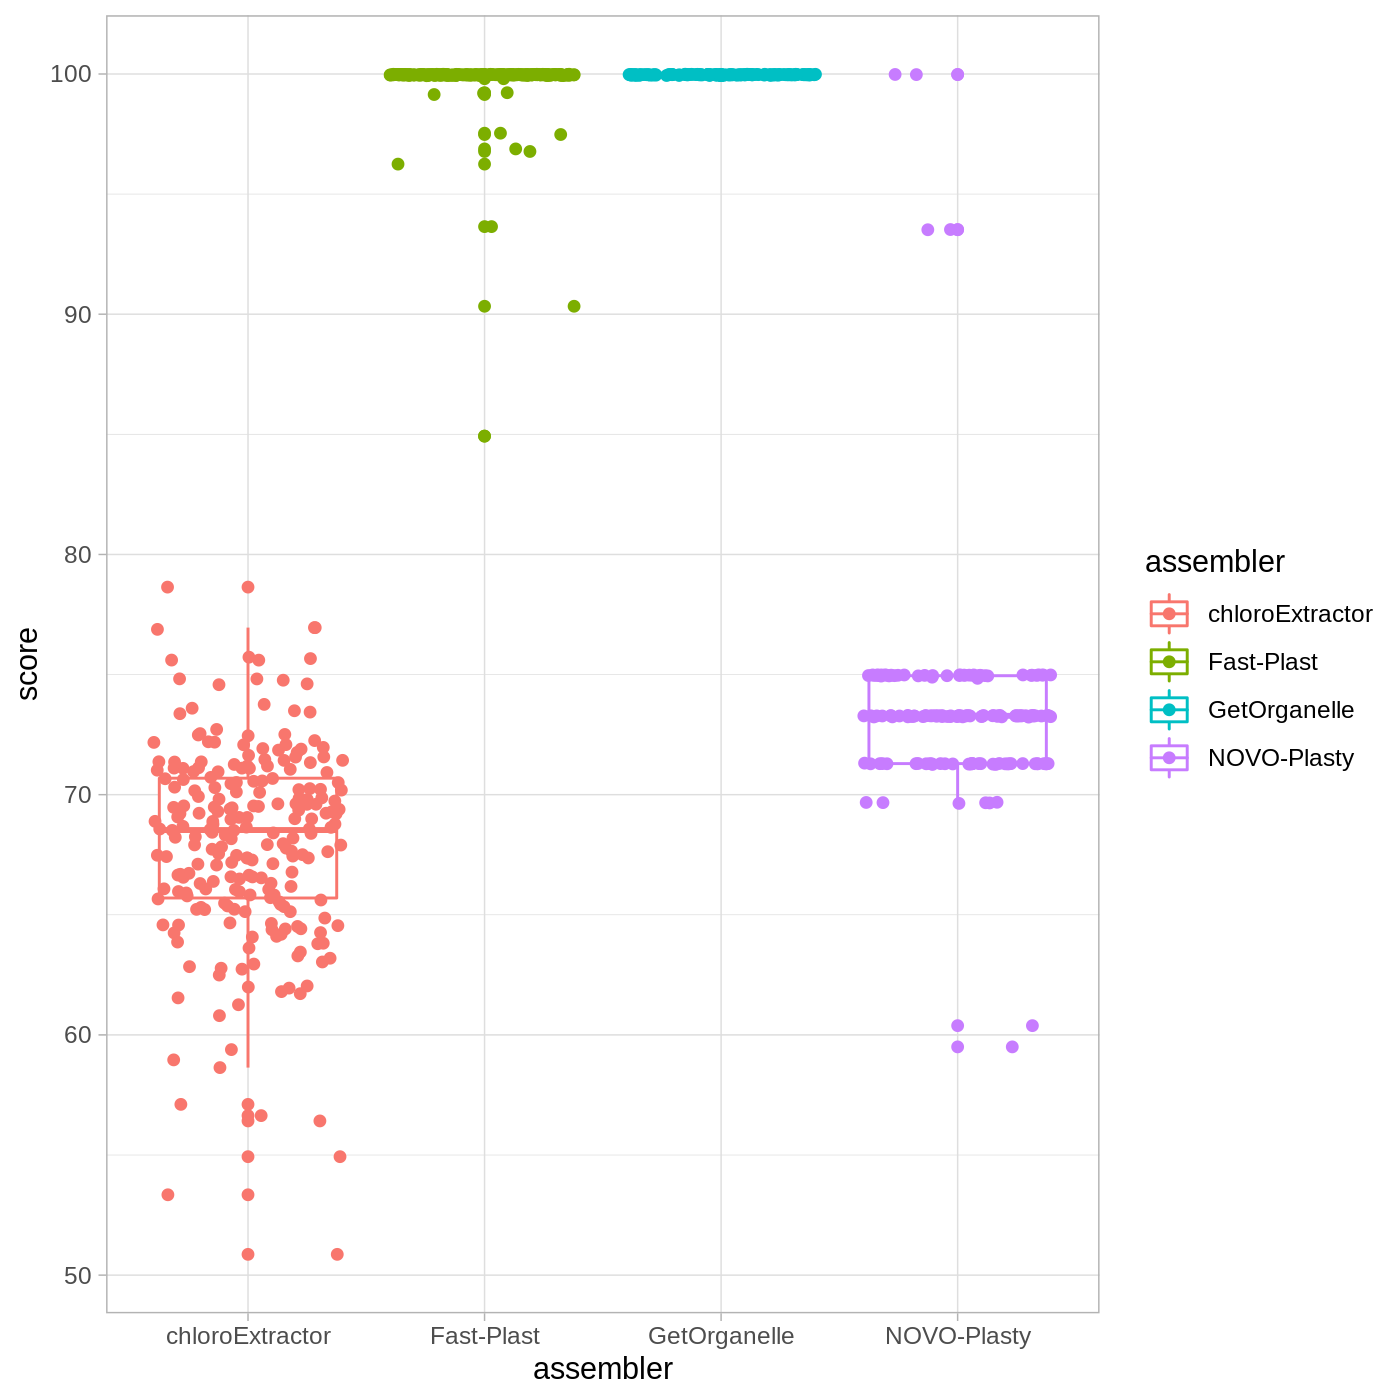

In [30]:
data %>% ggplot(aes(assembler, score, color=assembler)) + geom_boxplot() + geom_jitter()

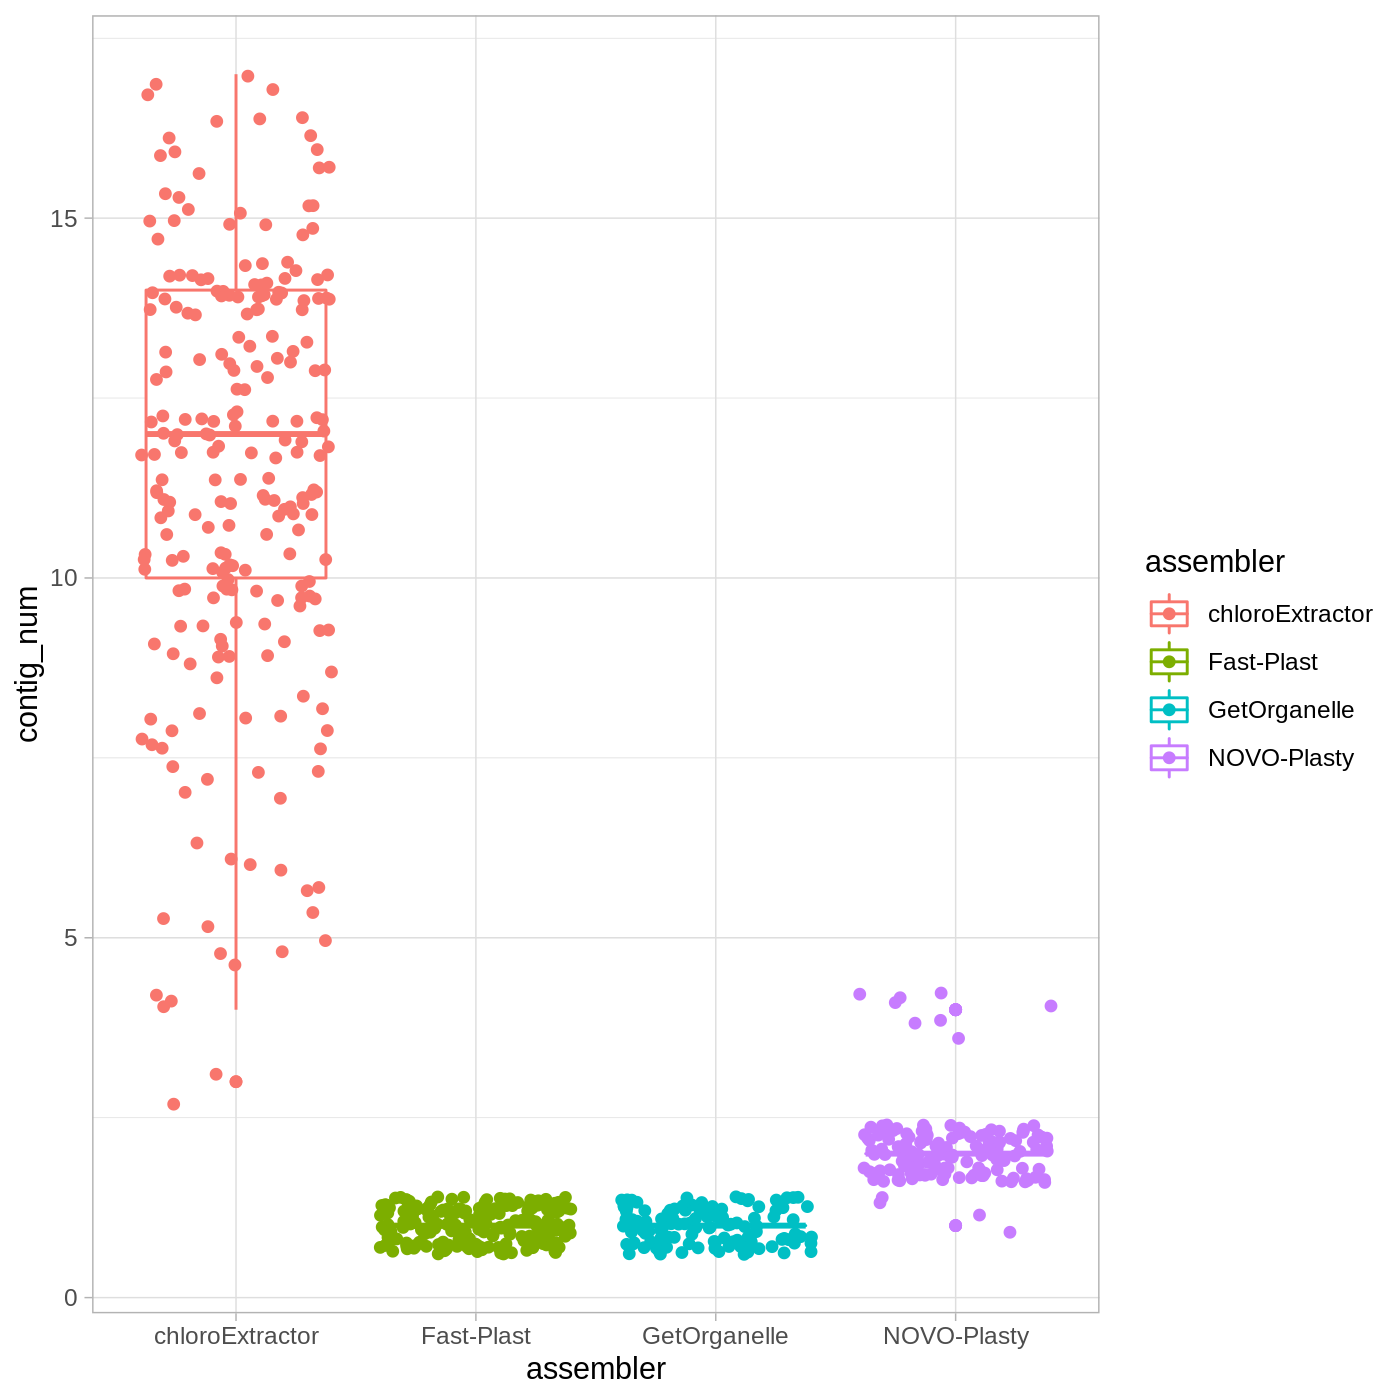

In [33]:
data %>% ggplot(aes(assembler, contig_num, color=assembler)) + geom_boxplot() + geom_jitter()

In [32]:
data %>% filter(assembler=="chloroExtractor") %>% summarize(mean(contig_num))

mean(contig_num)
<dbl>
11.37931


In [35]:
library(glue)


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [39]:
data %>% filter(success, score>95) %>% transmute(copy=glue("cp output/{dataset}/{assembler}/* success/{dataset}_{assembler}.fa")) %>% write_tsv("copy_success.sh", col_names = FALSE)